<a href="https://colab.research.google.com/github/linainsaf/Biometrics/blob/main/GAN_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BIoMétrie : Generative Adversarial Networks

### Import librairies 

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from numpy import vstack
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from keras.layers import Flatten,Conv2D,LeakyReLU,Dense,Conv2DTranspose,Reshape,Dropout,BatchNormalization,Activation


from IPython import display
from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn
from keras.models import Model, load_model,Sequential
from keras.layers import Input, Concatenate, Embedding
from keras import initializers
from keras.initializers import RandomNormal
from math import sqrt


2023-02-28 14:12:44.389766: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-28 14:12:44.498437: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-28 14:12:44.498449: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-28 14:12:44.967716: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

### Load Dataset

In [2]:
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32) / 127.5 - 1

11490434/11490434 [==============================] - 1s 0us/step


### Plot some images from the training set

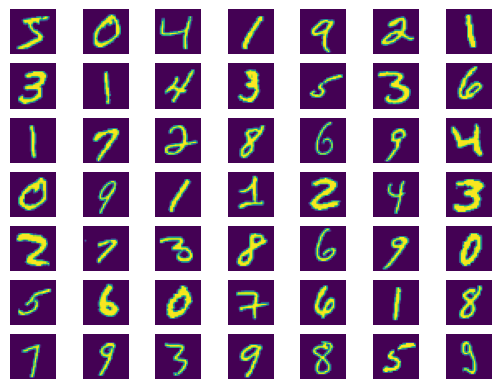

In [3]:
# example of loading and plotting the MNIST dataset
# plot images from the training dataset
for i in range(49):
    # define subplot
    plt.subplot(7, 7, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(X_train[i])
plt.show()

### Reshape Training data for DeepLearning : 

In [4]:
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)

(60000, 28, 28, 1)


### Instanciation of G and D

#### Define Generator : 

In [5]:
def define_generator(latent_dim): 
    init = RandomNormal(stddev=0.02)
    in_lat = Input(shape=(latent_dim,)) 
    gen = Dense(256, kernel_initializer=init)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(512, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(1024, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(28 * 28 * 1, kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    out_layer = Reshape((28, 28, 1))(gen)
    model = Model(in_lat, out_layer)
    return model

In [6]:
generator = define_generator(100)
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 256)               25856     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 1024)              0     

2023-02-28 14:12:48.607826: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-28 14:12:48.607842: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-28 14:12:48.607857: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (py4bd-06): /proc/driver/nvidia/version does not exist
2023-02-28 14:12:48.607987: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/stagiaire/anaconda3/lib/python3.9/site-packages/keras/initializers/in

#### Define Discriminator : 

In [7]:
def define_discriminator(in_shape=(28, 28, 1)):
    init = RandomNormal(stddev=0.02)  
    in_image = Input(shape=in_shape)
    fe = Flatten()(in_image)
    fe = Dense(1024)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(512)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(256)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    out = Dense(1, activation='sigmoid')(fe)
    model = Model(in_image, out)
    opt = Adam(lr=0.0002, beta_1=0.5) 
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [8]:
discriminator = define_discriminator()
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 1024)              803840    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0   

### Création du GAN

In [9]:
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # define gan output
    gan_output = discriminator(generator.output)
    model = Model(generator.input, gan_output)
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [10]:
gan.summary()

NameError: name 'gan' is not defined

### Apprentissage du GAN

In [ ]:
def generate_real_samples(X_train, n_samples):
    ix = randint(0, X_train.shape[0], n_samples) 
    X = X_train[ix]  
    y = ones((n_samples, 1)) 
    return X, y

def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)  
    z_input = x_input.reshape(n_samples, latent_dim)
    images = generator.predict(z_input)  
    y = zeros((n_samples, 1))
    return images, y

In [ ]:
# train the generator and discriminator
def train(g, d, gan, X_train, latent_dim, epochs=100, batch=256):
  bat_per_epo = int(X_train.shape[0] / batch)
  half_batch = int(batch / 2)
  step = 0
  for i in range(epochs):
    print('epoch number :', i+1)
    for j in range(bat_per_epo):
      X_real, y_real = generate_real_samples(X_train, half_batch)
      d_loss_r, d_acc_r = d.train_on_batch(X_real, y_real)
      X_fake, y_fake = generate_fake_samples(g, latent_dim, half_batch)
      d_loss_f, d_acc_f = d.train_on_batch(X_fake, y_fake)
      X_gan = randn(latent_dim * batch)
      X_gan = X_gan.reshape(batch, latent_dim)
      y_gan = ones((batch, 1))
      g_loss = gan.train_on_batch(X_gan, y_gan)
    if (i+1) % 10 == 0:
      step +=1
      print('g_loss=%.3f, d_loss_real=%.3f, d_acc_real=%.3f, d_loss_fake=%.3f, d_acc_fake=%.3f' % (g_loss, d_loss_r, d_acc_r,d_loss_f,d_acc_f))
      print("Generated images at this epoch : ")
      X_gen = randn(latent_dim * batch)
      X_gen = X_gen.reshape(batch, latent_dim)
      X_gen  = g.predict(X_gen)
      X_gen = (X_gen + 1) / 2.0
      for a in range(10):
        plt.subplot(2, 5, 1 + a)
        plt.axis('off')
        plt.imshow(X_gen[a, :, :, 0], cmap='gray_r')
      plt.show()
      filename = 'model_%04d.h5' % (step+1)
      g.save(filename)
      print('>Saved: %s' % (filename))

In [ ]:
gan = define_gan(generator,discriminator)

In [ ]:
train(generator, discriminator, gan, X_train, 100)


In [ ]:
def generate_samples_and_plot(g,latent_dim,batch):
  X_gen = randn(latent_dim * batch)
  X_gen = X_gen.reshape(batch, latent_dim)
  X_gen  = g.predict(X_gen)
  X_gen = (X_gen + 1) / 2.0
  plt.figure(figsize=(10, 10))
  for a in range(50):
    plt.subplot(10, 5, 1 + a)
    plt.axis('off')
    plt.imshow(X_gen[a, :, :, 0], cmap='gray_r')
  plt.show()
  return X_gen

In [ ]:
g = load_model('model_0011.h5')
latent_dim=100
batch = 200
X_gen = generate_samples_and_plot(g,latent_dim,batch)